# Анализ данных по продажам игр
Мы работаем в интернет-магазине, который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

### Открываем файл с данными и изучаем общую информацию

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

In [32]:
try:
    data = pd.read_csv('games.csv')
except:
    data = pd.read_csv('/datasets/games.csv')

In [33]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


### Столбцы датафрейма:
* Name — название игры
* Platform — платформа
* Year_of_Release — год выпуска
* Genre — жанр игры
* NA_sales — продажи в Северной Америке (миллионы проданных копий)
* EU_sales — продажи в Европе (миллионы проданных копий)
* JP_sales — продажи в Японии (миллионы проданных копий)
* Other_sales — продажи в других странах (миллионы проданных копий)
* Critic_Score — оценка критиков (максимум 100)
* User_Score — оценка пользователей (максимум 10)
* Rating — рейтинг от организации ESRB (Entertainment Software Rating Board), которая присваивает играм возрастную категорию: Е - Everyone (для всех возрастов), Т - Teen (для подростков), M - Mature (для взрослых)

### Подготовка данных: преобразуем типы, работаем с пропусками, приводим названия столбцов к нижнему регистру

In [34]:
data.columns= data.columns.str.lower()
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

Поскольку год почему-то во float, а иных сведений о дате нет, в тип datetime не преобразуешь. Ограничиваемся int, для которого надо сначала заполнить пропуски - заполняем их нулями. Заодно здесь же заполняем пропуски в столбце rating значением Unknown.

In [35]:
data['year_of_release'] = data['year_of_release'].fillna(0)
data['year_of_release'] = data['year_of_release'].astype('int')

data['rating'] = data['rating'].fillna('Unknown')

In [36]:
print(data['user_score'].unique()) # проверяем, какие есть значения оценок
print(data['critic_score'].unique())

['8' nan '8.3' '8.5' '6.6' '8.4' '8.6' '7.7' '6.3' '7.4' '8.2' '9' '7.9'
 '8.1' '8.7' '7.1' '3.4' '5.3' '4.8' '3.2' '8.9' '6.4' '7.8' '7.5' '2.6'
 '7.2' '9.2' '7' '7.3' '4.3' '7.6' '5.7' '5' '9.1' '6.5' 'tbd' '8.8' '6.9'
 '9.4' '6.8' '6.1' '6.7' '5.4' '4' '4.9' '4.5' '9.3' '6.2' '4.2' '6' '3.7'
 '4.1' '5.8' '5.6' '5.5' '4.4' '4.6' '5.9' '3.9' '3.1' '2.9' '5.2' '3.3'
 '4.7' '5.1' '3.5' '2.5' '1.9' '3' '2.7' '2.2' '2' '9.5' '2.1' '3.6' '2.8'
 '1.8' '3.8' '0' '1.6' '9.6' '2.4' '1.7' '1.1' '0.3' '1.5' '0.7' '1.2'
 '2.3' '0.5' '1.3' '0.2' '0.6' '1.4' '0.9' '1' '9.7']
[76. nan 82. 80. 89. 58. 87. 91. 61. 97. 95. 77. 88. 83. 94. 93. 85. 86.
 98. 96. 90. 84. 73. 74. 78. 92. 71. 72. 68. 62. 49. 67. 81. 66. 56. 79.
 70. 59. 64. 75. 60. 63. 69. 50. 25. 42. 44. 55. 48. 57. 29. 47. 65. 54.
 20. 53. 37. 38. 33. 52. 30. 32. 43. 45. 51. 40. 46. 39. 34. 35. 41. 36.
 28. 31. 27. 26. 19. 23. 24. 21. 17. 22. 13.]


Помимо пропусков, встречается также строка TBD - to be decided, требует уточнения. Поскольку рейтинг имеет численное значение, эти строки мешают привести тип к int или float; при этом заменить нулями тоже не выходит из-за того, что есть значения рейтинга 0. Считаю, что хорошим выходом будет привести пропуски и TBD к значению -1.
Также заметно, что значения user_score отличается в 10 раз от значений critic_score. Выглядит хорошей идеей привести их к одному порядку (от 0 до 100) и перевести в int.

In [37]:
data['user_score'] = data['user_score'].fillna(-1)
data.loc[data['user_score'] == 'tbd', 'user_score'] = -1
data['user_score'] = data['user_score'].astype('float')
data['user_score'] = data['user_score'] * 10
data['user_score'] = data['user_score'].astype('int')
data.loc[data['user_score'] == -10, 'user_score'] = -1
print(data['user_score'].unique())

[80 -1 83 85 66 84 86 77 63 74 82 90 79 81 87 71 34 53 48 32 89 64 78 75
 26 72 92 70 73 43 76 57 50 91 65 88 69 94 68 61 67 54 40 49 45 93 62 42
 60 37 41 58 56 55 44 46 59 39 31 29 52 33 47 51 35 25 19 30 27 22 20 95
 21 36 28 18 38  0 16 96 24 17 11  3 15  7 12 23  5 13  2  6 14  9 10 97]


In [38]:
data['critic_score'] = data['critic_score'].fillna(-1)
data['critic_score'] = data['critic_score'].astype('int')
print(data['critic_score'].unique())

[76 -1 82 80 89 58 87 91 61 97 95 77 88 83 94 93 85 86 98 96 90 84 73 74
 78 92 71 72 68 62 49 67 81 66 56 79 70 59 64 75 60 63 69 50 25 42 44 55
 48 57 29 47 65 54 20 53 37 38 33 52 30 32 43 45 51 40 46 39 34 35 41 36
 28 31 27 26 19 23 24 21 17 22 13]


Считаем суммарные продажи во всех регионах.

In [39]:
data['all_sales'] = data[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1) # исправлено
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,all_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,80,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1,-1,Unknown,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,83,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,80,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1,-1,Unknown,31.38


In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16715 non-null  int64  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     16715 non-null  int64  
 9   user_score       16715 non-null  int64  
 10  rating           16715 non-null  object 
 11  all_sales        16715 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.5+ MB


Мы заполнили пропуски там, где это возможно (кроме полей name и genre, где есть 2 пропуска), а также создали отдельный столбец для суммы продаж по всем регионам.

### Исследовательский анализ данных

Смотрим, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?

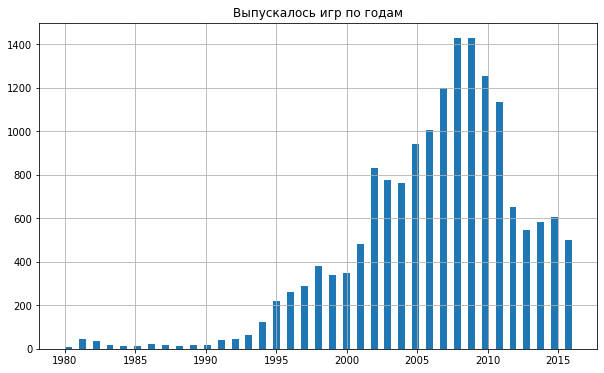

In [41]:
year_min = data['year_of_release'].loc[data['year_of_release'] > 0].min() # поскольку пропуски заменены нулями, эти нули
# не должны мешать в построении графика/гистограммы
year_max = data['year_of_release'].max()
plt.title('Выпускалось игр по годам')
data['year_of_release'].hist(range=(year_min, year_max), bins=(year_max - year_min)*2 + 1, figsize=(10,6));
plt.show()

В промежуток 1980-1994 выпускалось очень мало игр, и этот диапазон можно отбросить.

Теперь смотрим, как менялись продажи по платформам. Выбираем платформы с наибольшими суммарными продажами и строим распределение по годам. Выяснить: за какой характерный срок появляются новые и исчезают старые платформы?

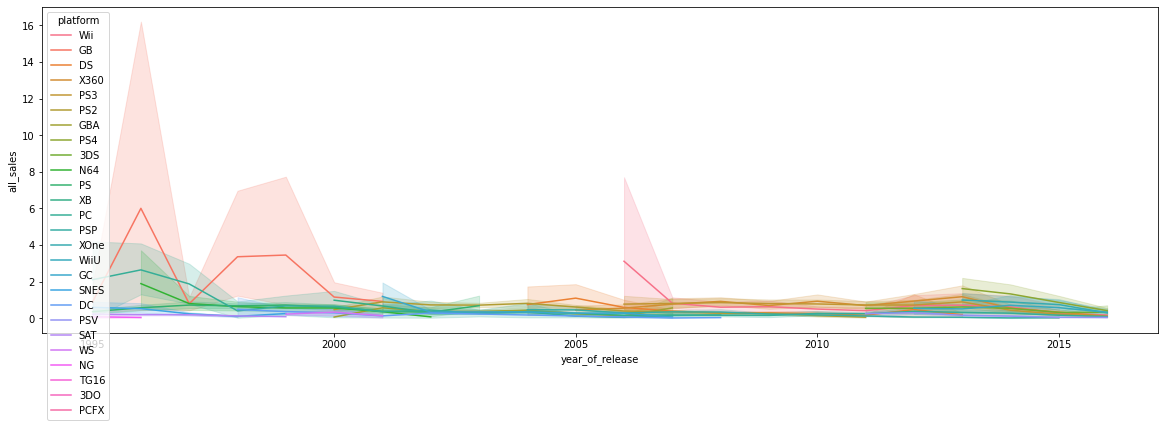

In [42]:
plt.figure(figsize=(20, 6))
ax = sns.lineplot(x='year_of_release', y='all_sales', hue="platform",
                  data=data.query('year_of_release > 1994') # исключаем совсем старые годы выпуска
                 )
plt.show()

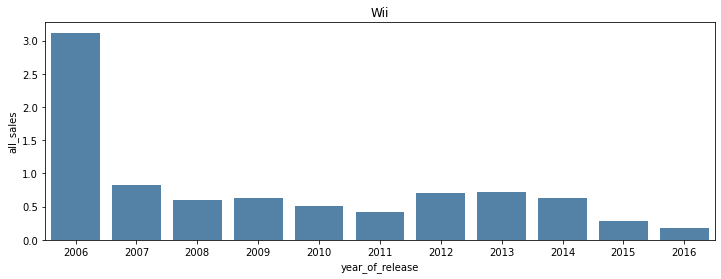

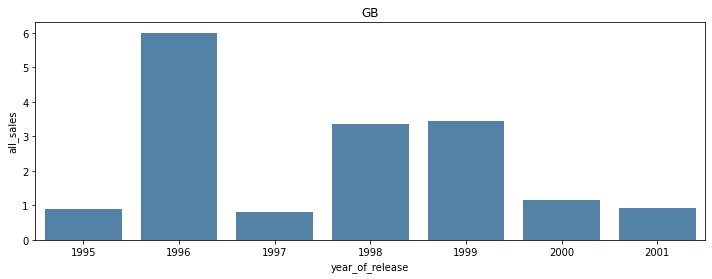

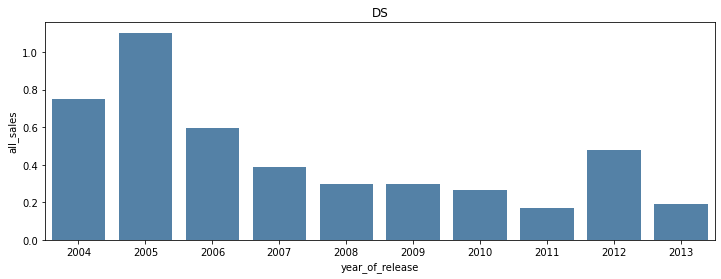

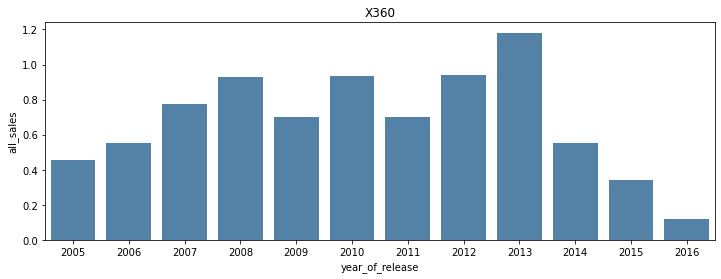

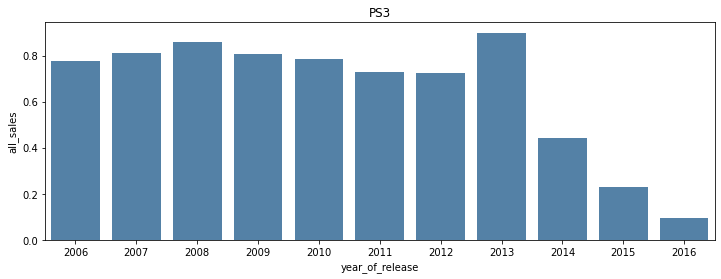

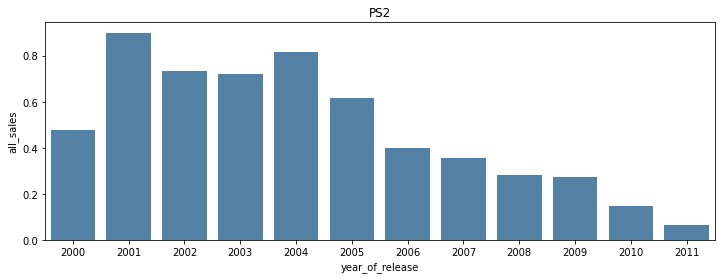

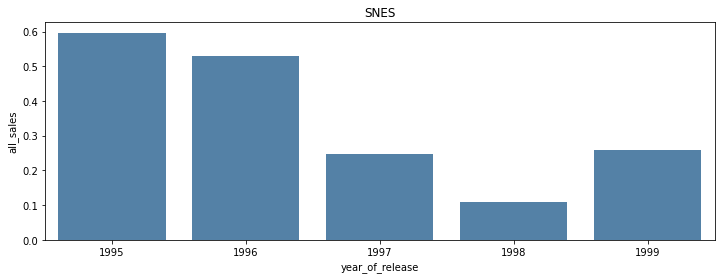

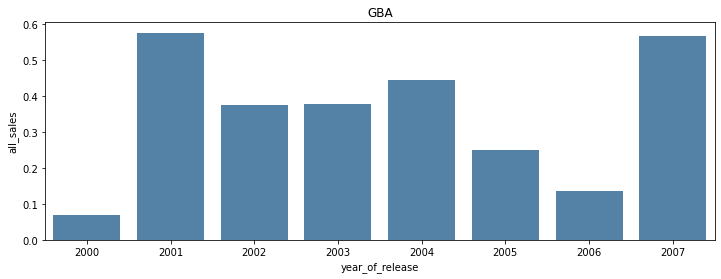

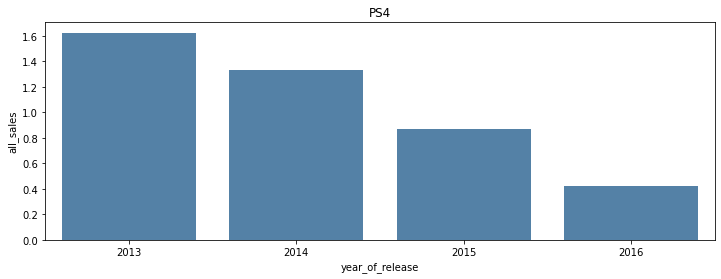

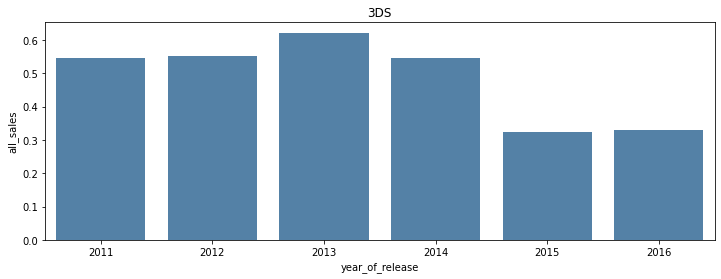

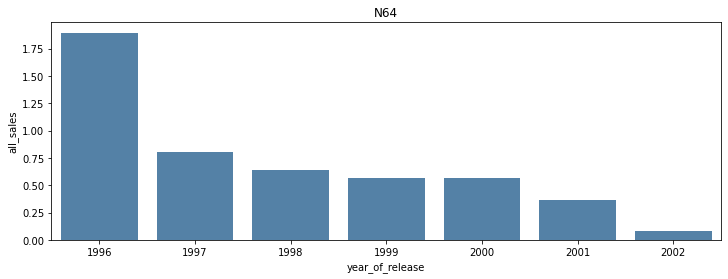

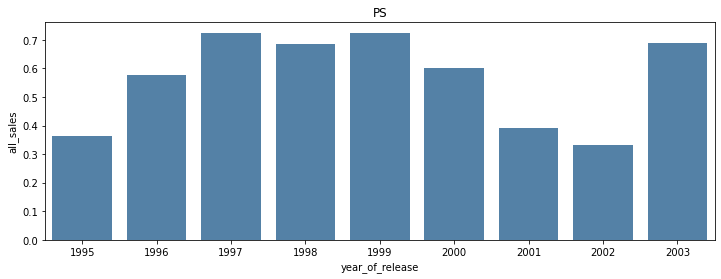

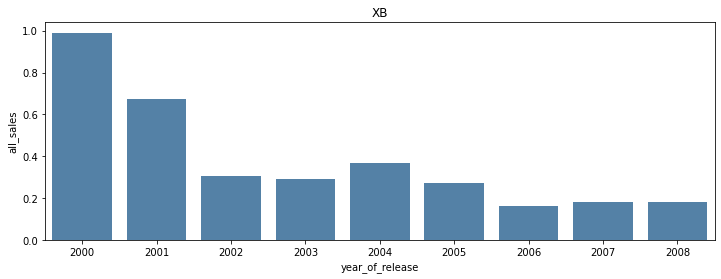

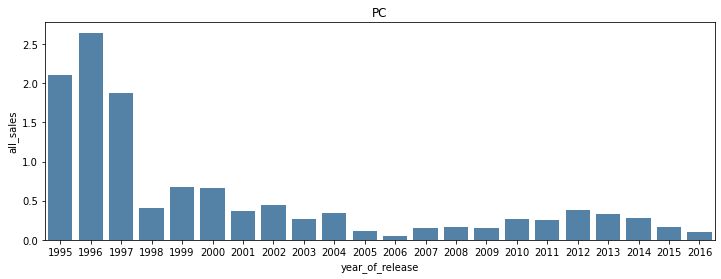

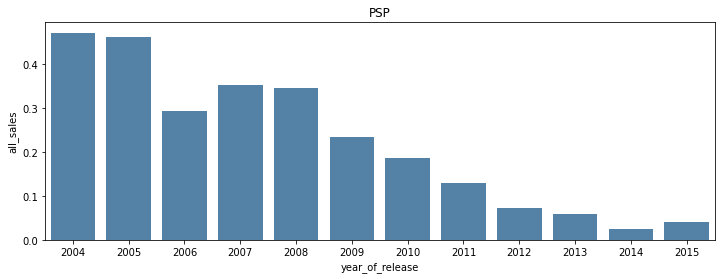

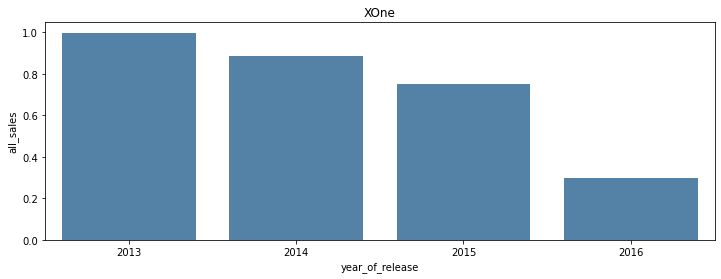

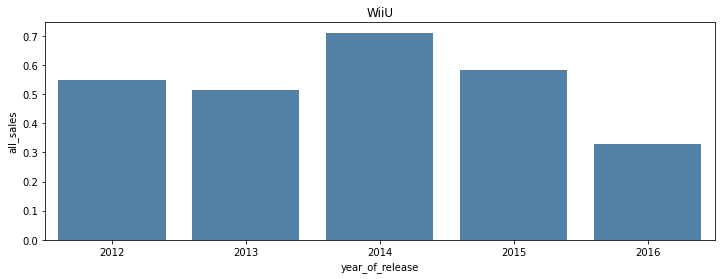

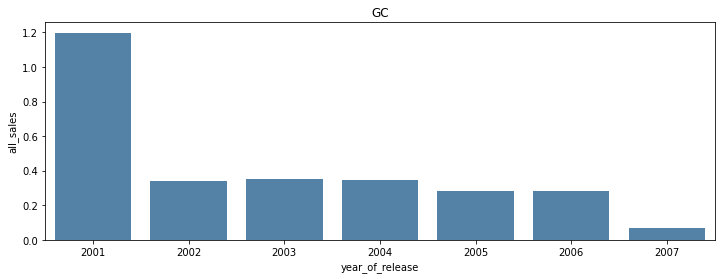

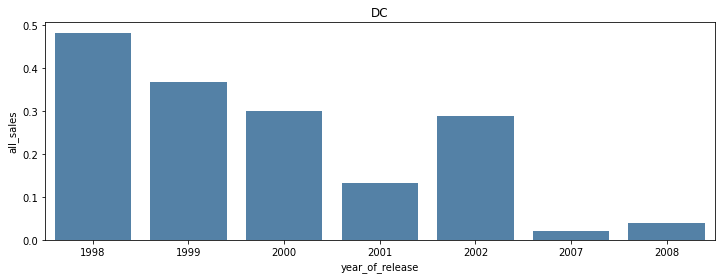

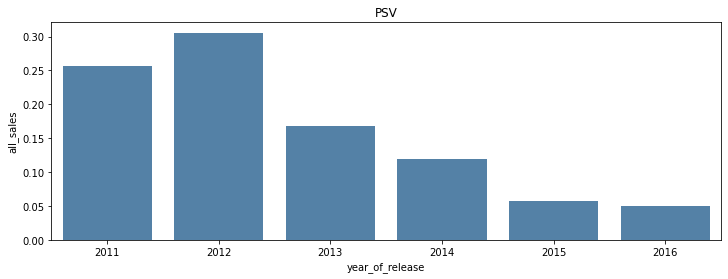

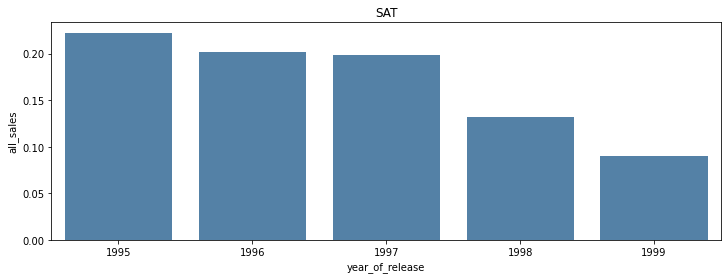

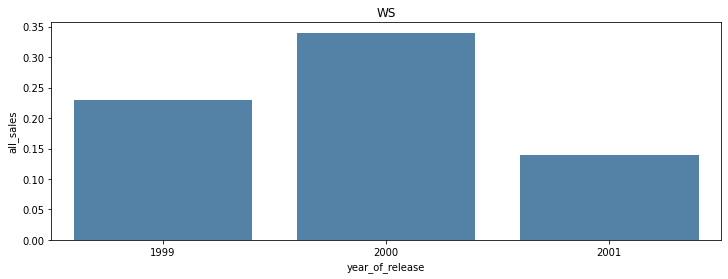

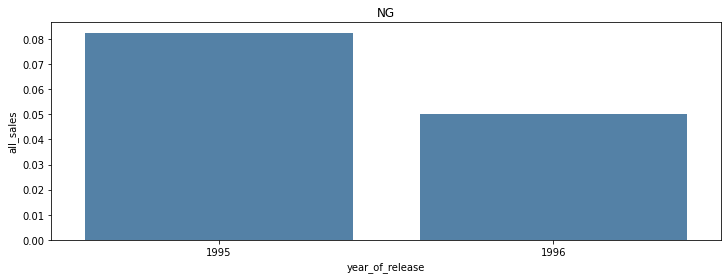

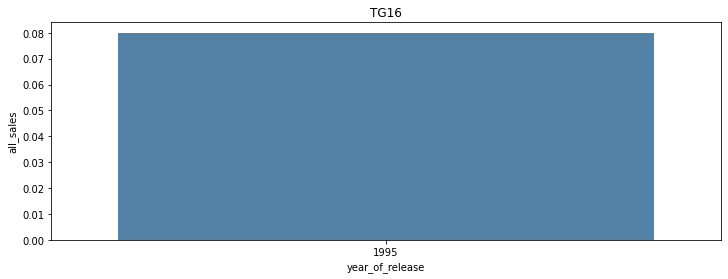

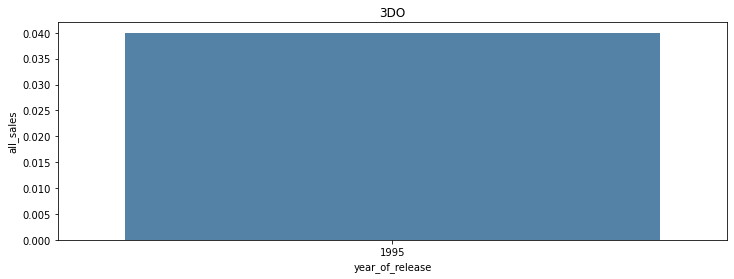

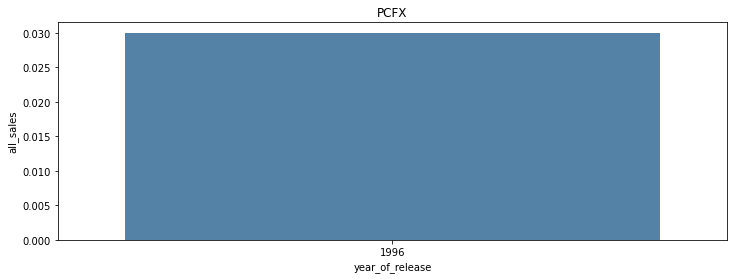

In [43]:
platforms = data['platform'].unique()

for platform in platforms:
    if len(data.loc[(data['year_of_release'] > 1994) & (data['platform'] == platform)]) != 0:
        # проверка, что список не пустой
        plt.figure(figsize=(12, 4))
        plt.title(platform)
        sns.barplot(x='year_of_release', y='all_sales',
                  data=data.loc[(data['year_of_release'] > 1994) & (data['platform'] == platform)],
                   ci=None, color='steelblue')
        plt.show()
    else:
        pass

In [44]:
data_clean = data.loc[data['year_of_release'] != 0] # фильтруем заглушки-нули, чтобы не мешались в расчёте
platform_year_min = data_clean.groupby('platform')['year_of_release'].min()
platform_year_max = data_clean.groupby('platform')['year_of_release'].max()
life_cycle = platform_year_max - platform_year_min
life_cycle.median()

6.0

"Жизненный цикл" платформы в среднем составляет 6 лет.

Поскольку новый жизненный цикл начался в 2013 (именно с этого года начинаются продажи игр на PS4, Xbox One и иных "новых" платформах), за актуальный период берём данные 2013-2016. Смотрим, какие платформы лидируют по продажам, растут или падают, выбираем потенциально прибыльные.

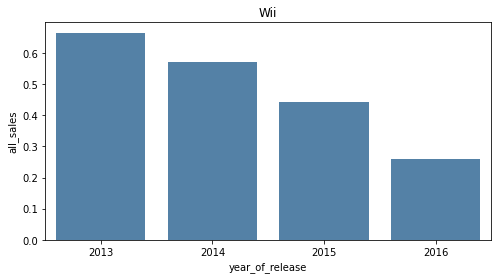

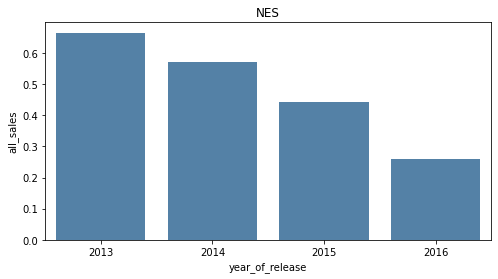

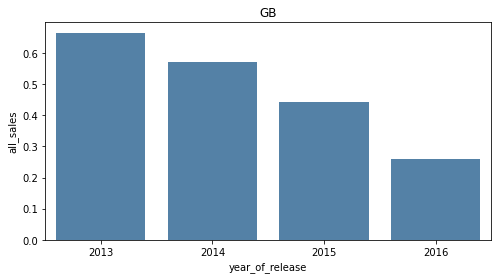

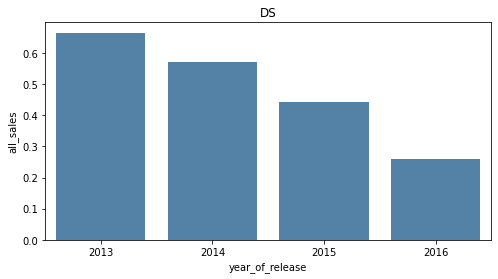

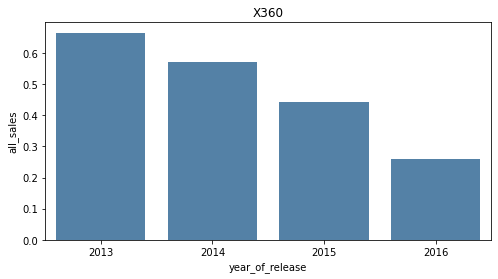

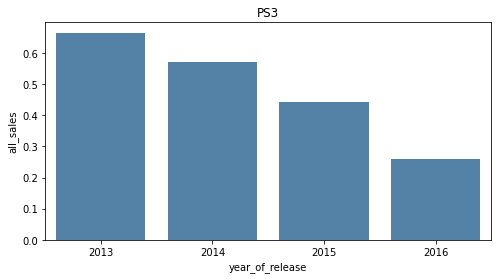

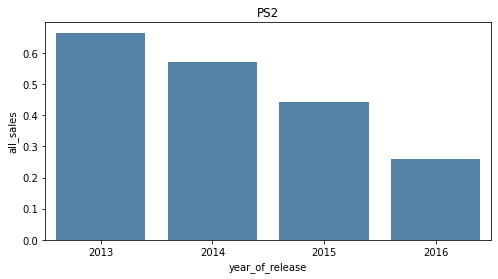

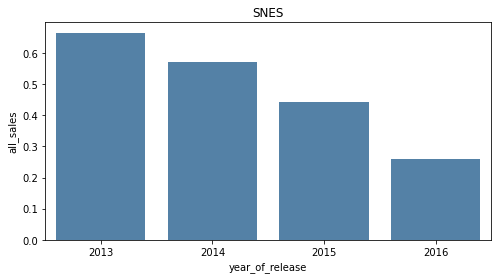

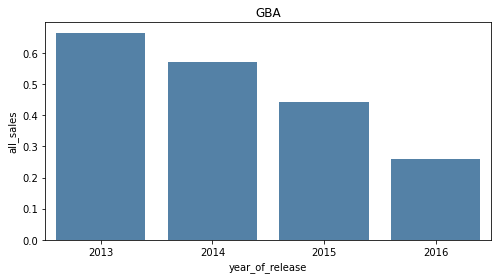

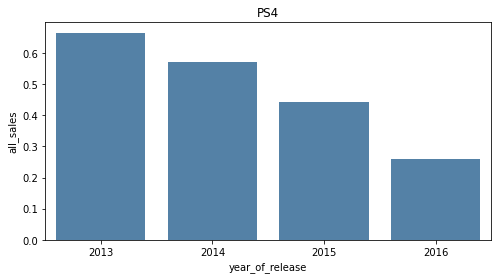

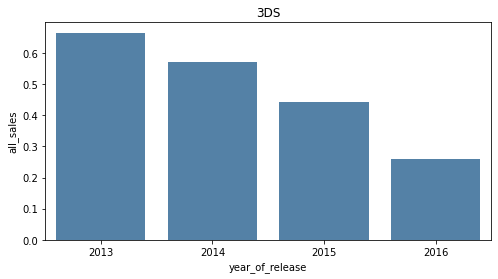

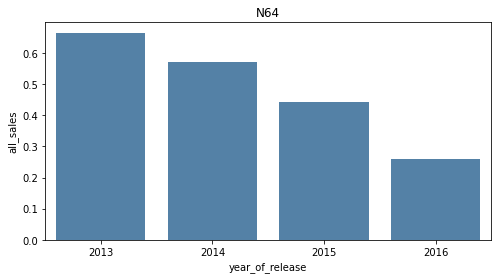

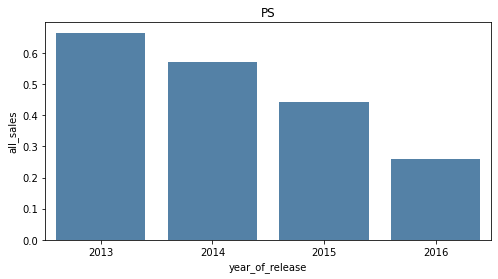

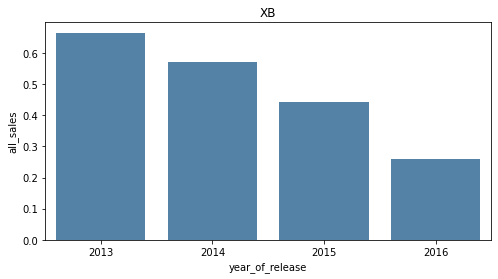

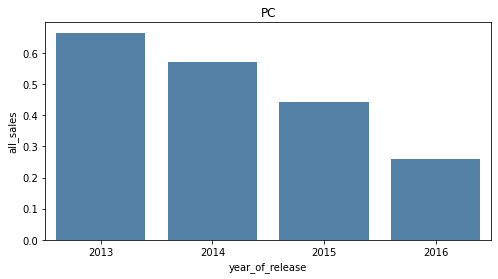

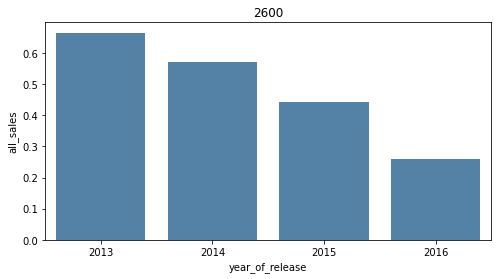

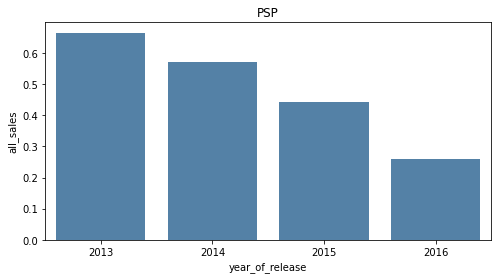

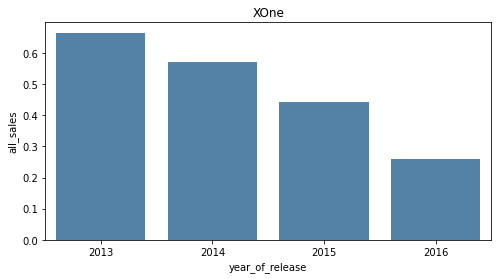

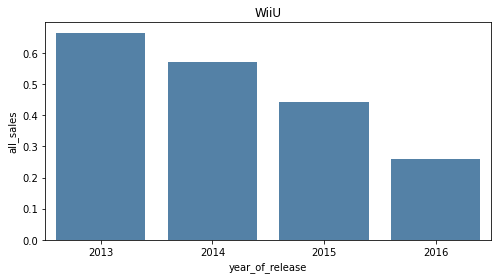

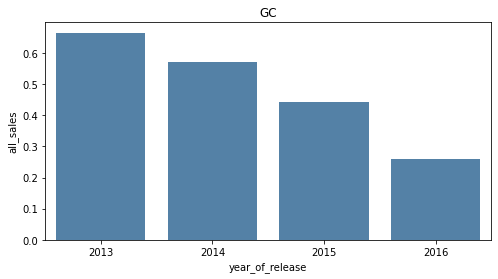

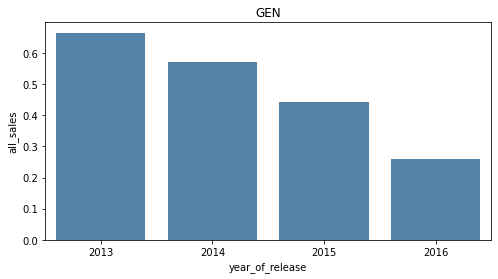

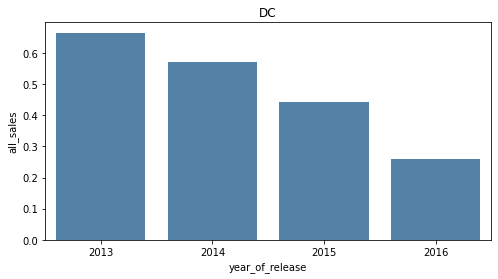

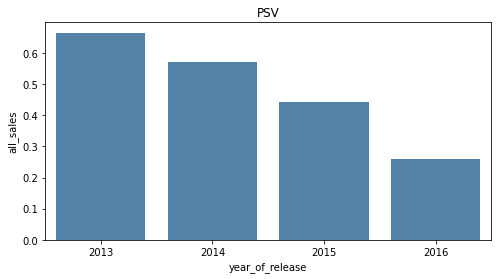

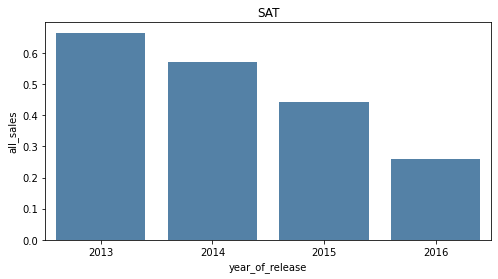

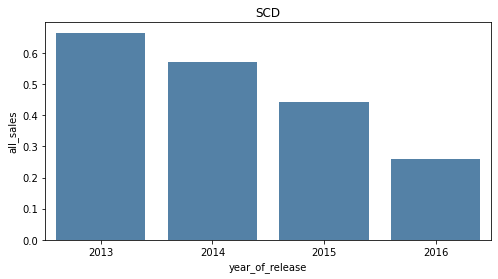

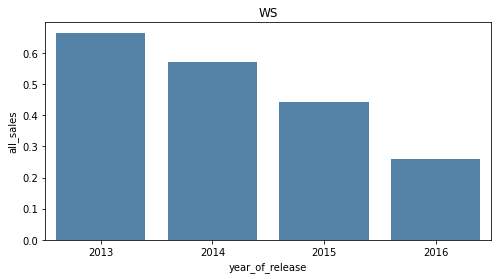

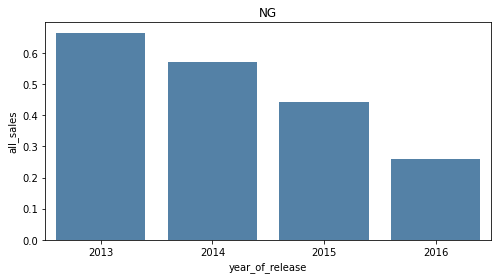

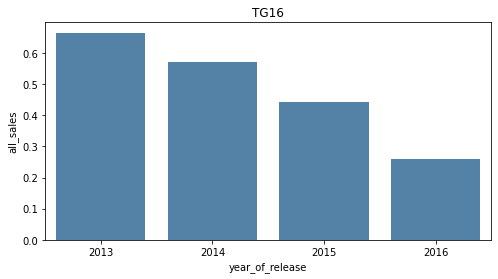

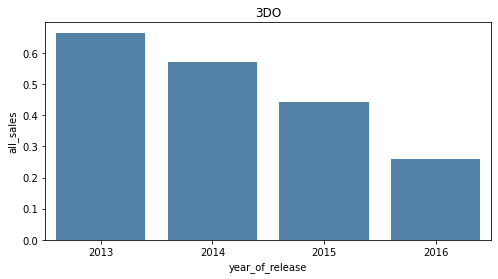

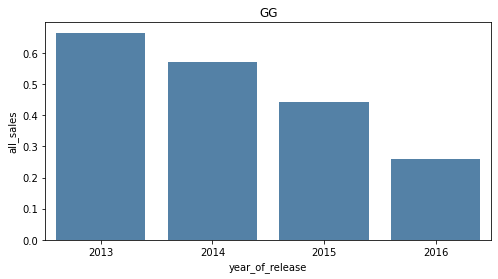

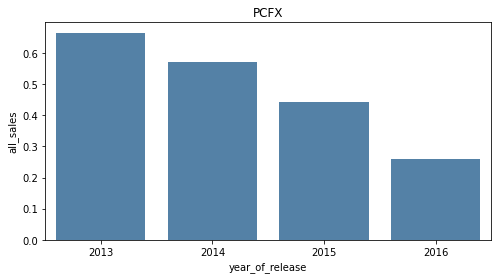

In [45]:
data_actual = data.loc[data['year_of_release'] >= 2013]
# старый код на случай, если пригодится
# plt.figure(figsize=(15, 6))
# ax2 = sns.lineplot(x='year_of_release', y='all_sales', hue='platform', data=data_actual)
# plt.show()
# data_actual.head()

for platform in platforms:
    plt.figure(figsize=(8, 4))
    plt.title(platform)
    sns.barplot(x='year_of_release', y='all_sales',
                data=data_actual, ci=None, color='steelblue')
    plt.show()

Прибыльные платформы: PS4, Xbox One, 3DS (популярность растёт), PC (популярность стабильна). Возможно, Wii/WiiU.

Строим график «ящик с усами» по глобальным продажам игр в разбивке по платформам.

,count,mean,std,min,25%,50%,75%,max
platform,,,,,,,,
3DS,303.0,0.472772,1.381347,0.01,0.0400,0.090,0.2800,14.60
DS,8.0,0.192500,0.172026,0.03,0.0675,0.150,0.2525,0.51
PC,189.0,0.208624,0.352304,0.01,0.0300,0.080,0.2300,3.05
PS3,345.0,0.525884,1.451939,0.01,0.0400,0.150,0.5100,21.05
PS4,392.0,0.801378,1.609456,0.01,0.0600,0.200,0.7300,14.63
PSP,67.0,0.052239,0.059768,0.01,0.0150,0.020,0.0700,0.24
PSV,358.0,0.092151,0.153816,0.01,0.0200,0.040,0.1100,1.96
Wii,23.0,0.593913,0.915432,0.01,0.0450,0.180,0.7550,3.58
WiiU,115.0,0.562000,1.038778,0.01,0.0600,0.200,0.5950,7.09


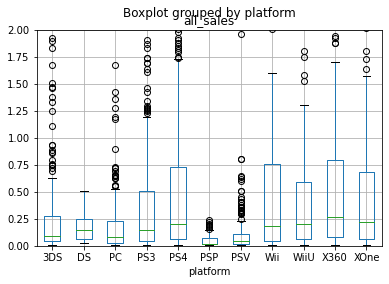

In [46]:
data_actual.boxplot(column='all_sales', by='platform')
plt.ylim(0, 2)
data_actual.groupby('platform')['all_sales'].describe()

По диаграмме размаха можно выделить лидирующие по объёму продаж платформы точнее: это PS3, PS4, Wii, WiiU, Xbox 360, Xbox One. В сочетании с графиком также заметно, что платформы Nintendo и РС имеют более низкие, но относительно стабильные продажи, в то время как PS3 и Xbox 360 движутся к концу своего жизненного цикла. Выбросы на графике связаны с крупными популярными проектами, которых немного, но которые внесли большой вклад в количество продаж.

Теперь нужно посмотреть, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Строим диаграмму рассеяния и считаем корреляцию между отзывами и продажами.

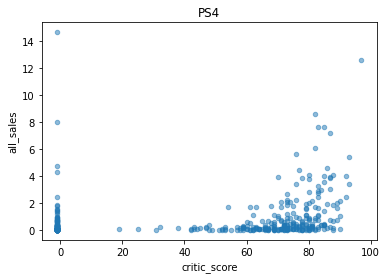

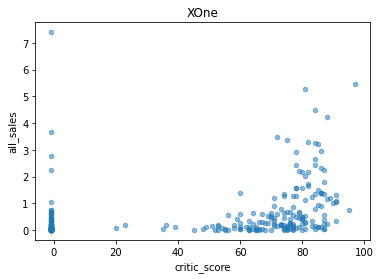

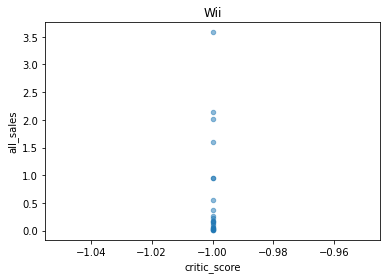

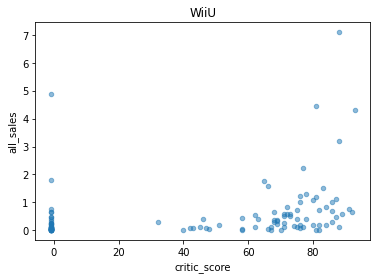

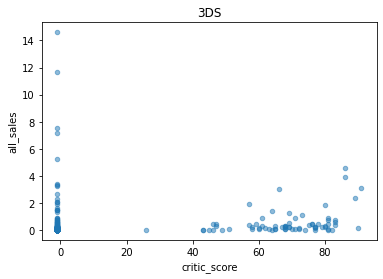

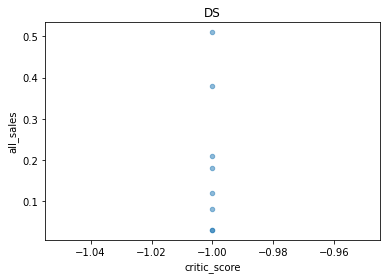

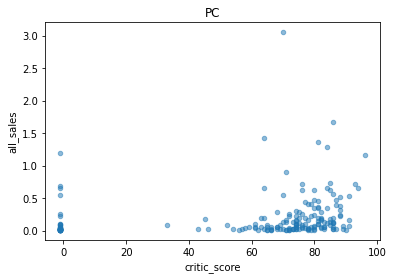

In [47]:
popular_platform = ['PS4', 'XOne', 'Wii', 'WiiU', '3DS', 'DS', 'PC']
# data_actual_clean = data_actual.loc[(data_actual['critic_score'] != -1) & (data_actual['user_score'] != -1)]
for i in popular_platform:
    data_actual.loc[data_actual['platform'] == i].plot(
        x='critic_score', y='all_sales', kind='scatter', alpha=0.5, title=i)

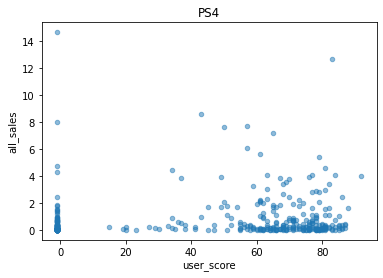

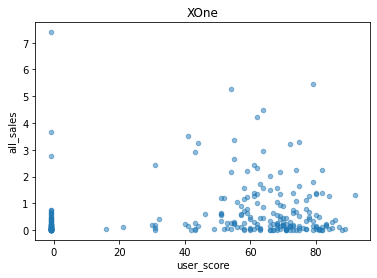

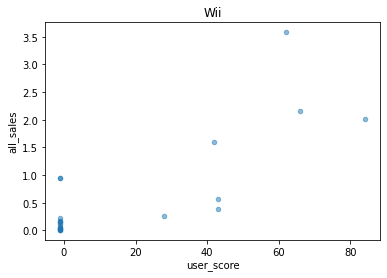

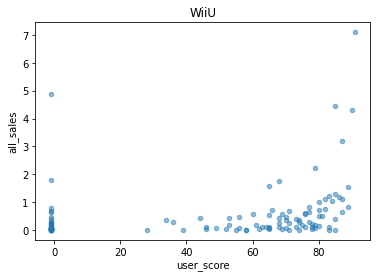

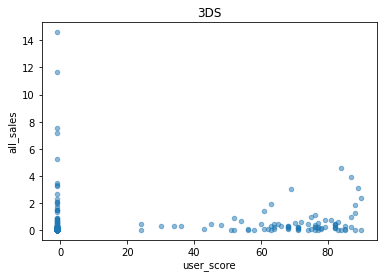

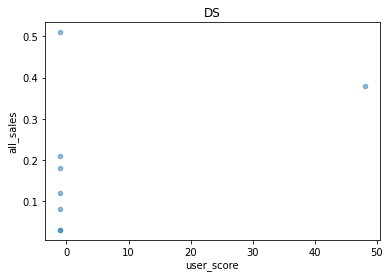

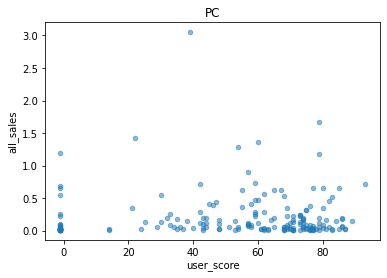

In [48]:
for i in popular_platform:
    data_actual.loc[data_actual['platform'] == i].plot(x='user_score', y='all_sales', kind='scatter', alpha=0.5, title=i)

In [49]:
data_actual_clean = data_actual.loc[(data_actual['critic_score'] != -1) & (data_actual['user_score'] != -1)]
print('Отзывы критиков и продажи:')
for i in popular_platform:
    print(i, data_actual_clean.loc[data_actual_clean['platform'] == i]['all_sales'].corr(
        data_actual_clean.loc[data_actual_clean['platform'] == i]['critic_score']))

Отзывы критиков и продажи:
PS4 0.40589480145836687
XOne 0.4104220356129637
Wii nan
WiiU 0.37950449899784144
3DS 0.33923492878531464
DS nan
PC 0.19412407903472953


In [50]:
print('Отзывы пользователей и продажи:')
for i in popular_platform:
    print(i, data_actual_clean.loc[data_actual_clean['platform'] == i]['all_sales'].corr(
        data_actual_clean.loc[data_actual_clean['platform'] == i]['user_score']))

Отзывы пользователей и продажи:
PS4 -0.03362497596528887
XOne -0.09400318326920865
Wii nan
WiiU 0.408691743849265
3DS 0.27299043669424433
DS nan
PC -0.10923502736171793


Можно заметить, что корреляция между отзывами (*как пользователей, так и критиков*) и продажами весьма слаба, причём с пользовательскими отзывами на некоторых платформах (Xbox One, PS4, PC) отрицательная, но тоже очень слабая:
* с отзывами критиков: на PlayStation 4, Xbox One, Wii U, Nintendo 3DS - слабо выраженная положительная, на остальных платформах корреляции нет
* с отзывами пользователей: слабо выраженная положительная на Wii U и Nintendo 3DS, на остальных платформах нет.

Теперь взглянем на общее распределение игр по жанрам:
1. Какие жанры самые прибыльные?
2. Выделяются ли жанры с высокими и низкими продажами?

In [21]:
data_actual.groupby('genre')['all_sales'].median().sort_values(ascending=False)

genre
Shooter         0.450
Sports          0.240
Platform        0.225
Role-Playing    0.125
Fighting        0.125
Racing          0.120
Action          0.110
Simulation      0.100
Misc            0.100
Strategy        0.080
Puzzle          0.060
Adventure       0.030
Name: all_sales, dtype: float64

Наиболее прибыльные жанры - шутер, спортивный симулятор, платформер, ролевая игра и файтинг; наименее - головоломки, стратегии и адвенчуры.

### Составляем портрет пользователя каждого региона

Определяем для пользователя каждого региона (NA, EU, JP):
1. Самые популярные платформы (топ-5). Опишите различия в долях продаж.
2. Самые популярные жанры (топ-5). Поясните разницу.
3. Влияет ли рейтинг ESRB на продажи в отдельном регионе?

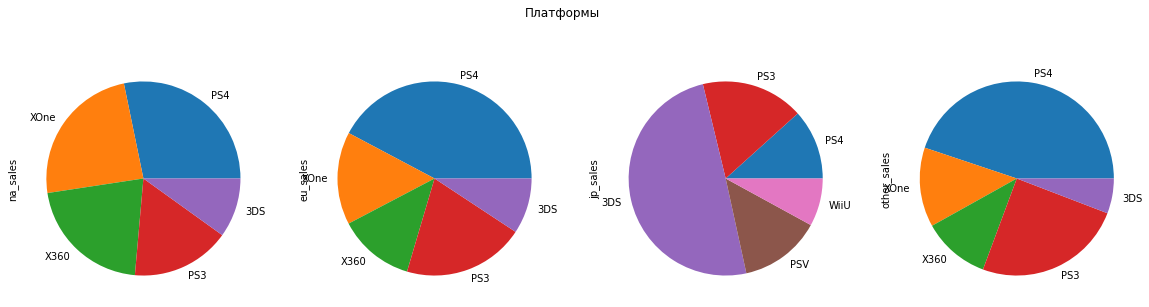

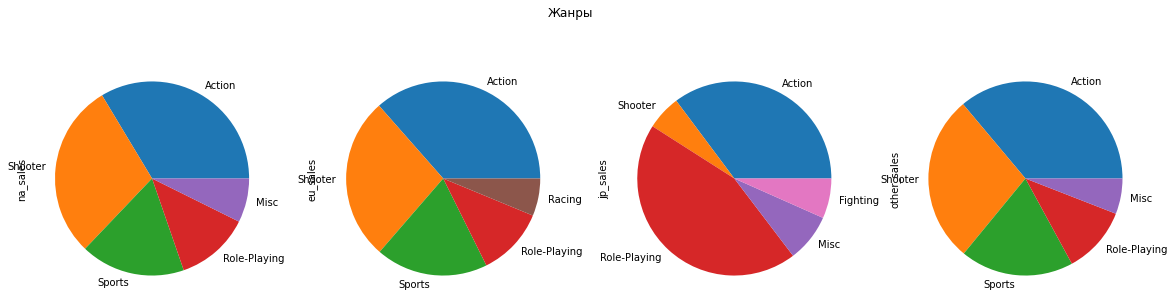

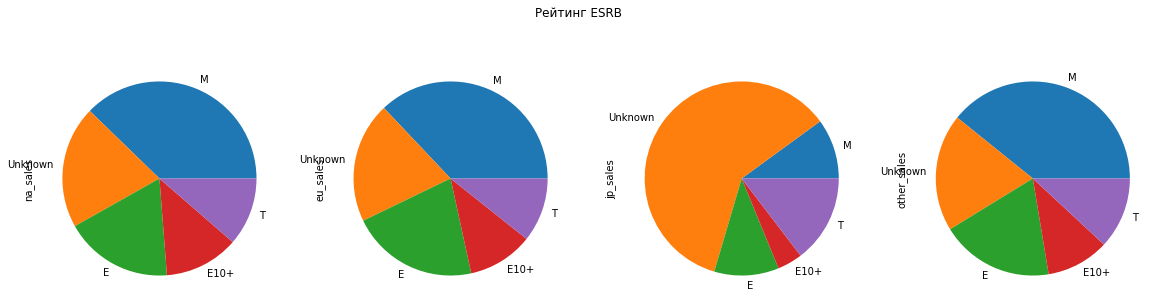

In [66]:
def regioning(data, col, region):
    return data.groupby(col)[region].sum().sort_values(ascending=False).head()
# функция для подсчёта продаж по регионам и передаваемому столбцу (платформа, жанр, рейтинг)

def pieplotting(data, title):
    return data.plot(kind='pie', subplots=True, figsize=(20,5), legend=False, title=title);

regions = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']
top5_list = []
# criteria = ['platform', 'genre', 'rating'] # сохраняем на случай, если я всё-таки додумаюсь

for region in regions:
    top5_list.append(regioning(data_actual, 'platform', region))

top5 = pd.DataFrame(top5_list).transpose()
# меняем строки и столбцы местами, чтобы правильно построить диаграммы
pieplotting(top5, 'Платформы');

top5_list.clear()
for region in regions:
    top5_list.append(regioning(data_actual, 'genre', region))
    
top5 = pd.DataFrame(top5_list).transpose()
pieplotting(top5, 'Жанры');

top5_list.clear()
for region in regions:
    top5_list.append(regioning(data_actual, 'rating', region))
    
top5 = pd.DataFrame(top5_list).transpose()
pieplotting(top5, 'Рейтинг ESRB');

1. Во всех регионах, кроме Японии, самой популярной консолью является PlayStation 4, при этом в Японии это Nintendo 3DS. PlayStation 3 и обе версии Xbox (360 и One) пользуются популярностью по всему миру.
2. Наиболее популярным жанром во всех регионах является экшн, на втором месте - шутер везде, кроме Японии (там на первом месте ролевые игры, на втором экшн).
3. Расклад по рейтингам одинаков для всех регионов, кроме опять-таки Японии: если в остальных регионах самый популярный рейтинг - Mature, то в Японии в топе игры, у которых нет данных о рейтинге.

# 📊 Шаг 5. Проверьте гипотезы
Задайте самостоятельно пороговое значение alpha.
Поясните:
Как вы сформулировали нулевую и альтернативную гипотезы;
Какой критерий применили для проверки гипотез и почему.    

### Проверяем гипотезы

### 📊 Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;

**Нулевая гипотеза 1**: средние пользовательские рейтинги платформ Xbox One и PC равны. **Альтернативная гипотеза 1**: эти рейтинги различны.

Задаём уровень значимости как 0.05.

In [52]:
xbone_score = data_actual_clean.loc[data_actual_clean['platform'] == 'XOne']['user_score']
pc_score = data_actual_clean.loc[data_actual_clean['platform'] == 'PC']['user_score']
# вернула очищенный от заглушек датафрейм, т.к. заглушки как раз в значениях рейтинга, по которым проверяем гипотезы
alpha = 0.05

result = st.ttest_ind(xbone_score, pc_score, equal_var=False)

print('p-значение:', result.pvalue)

if result.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.17882648263401374
Не получилось отвергнуть нулевую гипотезу


Средние пользовательские рейтинги Xbox One и PC одинаковы в пределах статистической значимости.

### 📊 Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

**Нулевая гипотеза 2**: средние пользовательские рейтинги жанров Action и Sports равны. **Альтернативная гипотеза 2**: эти рейтинги различны.

In [53]:
action_score = data_actual_clean.loc[data_actual_clean['genre'] == 'Action']['user_score']
sports_score = data_actual_clean.loc[data_actual_clean['genre'] == 'Sports']['user_score']

result2 = st.ttest_ind(action_score, sports_score, equal_var=False)
print('p-значение:', result2.pvalue)

if result2.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.0496920005009195e-13
Отвергаем нулевую гипотезу


А средние рейтинги этих жанров различаются.

### Общий вывод

Обработаны данные:
1. Названия столбцов приведены к единому виду (нижний регистр).
2. Приведены к единому стандарту (целое число от 0 до 100) значения пользовательских рейтингов и рейтингов критиков.
3. Создан отдельный столбец для суммарных продаж по всем регионам.
4. Обработан тип данных в столбце года выпуска (переведён в целое число).

Проанализировано:
1. Распределение количества вышедших игр по годам.
2. Средний жизненный цикл платформы (6 лет).
3. Найдены наиболее прибыльные платформы: Xbox One, PlayStation 4, Nintendo 3DS (в основном в Японии), PC (в Европе).
3. В отобранных платформах посчитана корреляция общего уровня продаж с отзывами пользователей и критиков. Замечено: эта корреляция нигде не превышает 0.41, а в большинстве случаев настолько мала, что можно заявить об её отсутствии.
4. Найдены наиболее популярные платформы и жанры по регионам, а также влияние рейтинга ESRB на продажи: игры с рейтингом М (Mature) более прибыльны во всех регионах, кроме Японии, где на первом месте Т (Teen).

Итоговые закономерности:
1. Наиболее популярные жанры в западных регионах - Action, Shooter, Sports; при этом распределение по рейтингу ESRB составляет M (Mature, для взрослых), неизвестный (нет данных о рейтинге или он не присвоен ESRB), E (Everyone, для всех возрастов). Топ-1 платформ держит PlayStation 4, также высокой популярностью пользуются PlayStation 3, Xbox 360 и Xbox One, но PS3 и Xbox 360 подходят к концу своего жизненного цикла, поэтому ориентироваться на продажи на этих платформах уже не стоит.
2. Картина в японском регионе отличается: Shooter совсем не популярен, зато на первом месте Role-Playing и на втором Action, по рейтингу же большинство не имеют оценки ESRB. Самая популярная платформа в регионе - Nintendo 3DS; вероятно, с этим связано и иное распределение жанров и рейтинга по популярности.